In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [13]:
dd = IMAS.json2imas("/Users/meneghini/.julia/dev/FUSE/sample/CAT_eq_ods.json");
plot(dd.equilibrium.time_slice[1])
IMAS.flux_surfaces(dd.equilibrium);

In [14]:
# Initialize layers of radial build explicitly
#
# rb=FUSE.init(IMAS.radial_build(),
#     Bmax_OH=11.0,
#     Bmax_TF=5.3,
#     gap_OH=1.0,
#     OH=0.12,
#     inner_TF=0.37,
#     inner_shield=0.01,
#     inner_blanket=0.22,
#     inner_wall=0.01,
#     vacuum_vessel=1,
#     outer_wall=0.01,
#     outer_blanket=0.22,
#     outer_shield=0.01
#     outer_TF=0.37
#     gap_cryostat=0.2
# )

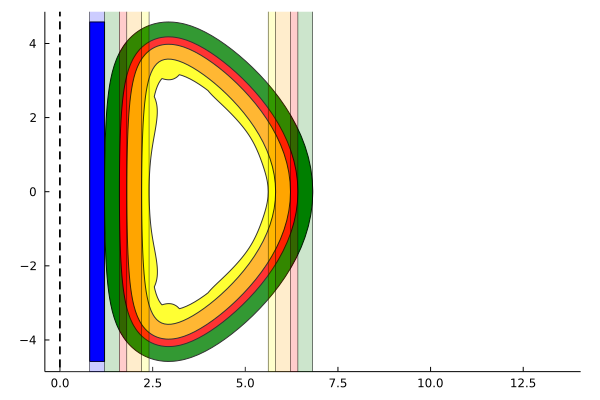

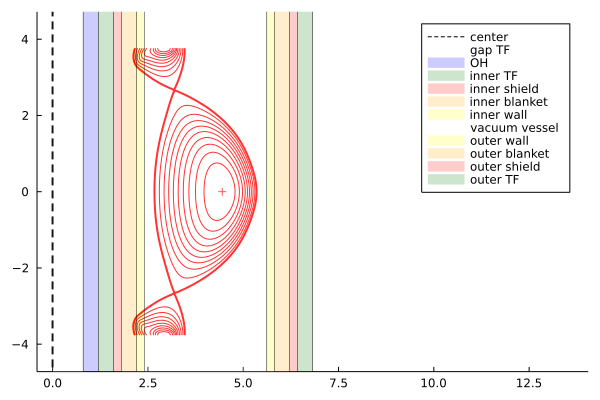

OH
inner TF
inner shield
inner blanket
inner wall
vacuum vessel


In [480]:
# initialize layers of radial build
rb=IMAS.radial_build()
FUSE.init(rb,dd.equilibrium.time_slice[1],is_nuclear_facility=true)
dd.radial_build=rb
eqt=dd.equilibrium.time_slice[1]
#display(rb)

function mypoly(x,y)
    if x[1]≈x[end]
        x[end]=x[1]
        y[end]=y[1]
    elseif x[1]!=x[end]
        push!(x,x[1])
        push!(y,y[1])
    end
    coords = [collect(map(collect,zip(x,y)))]
    polygon = LibGEOS.Polygon(coords)
end

function miller(R0,epsilon,kappa,delta,n)
    θ = range(0,2pi,length=n)
    δ₀ = asin(delta)
    x = R0*(1 .+ epsilon .* cos.(θ .+ δ₀*sin.(θ)))
    y = R0*(epsilon*kappa*sin.(θ))
    return (x,y)
end

function miller_conformal(rb,layer_id)
    layer_id=-abs(layer_id)
    Rstart_outer=IMAS.get_radial_build(rb, -layer_id).start_radius
    Rend_outer=IMAS.get_radial_build(rb, -layer_id).end_radius
    if layer_id==-1
        outer_line=miller(eqt.boundary.geometric_axis.r,(Rend_outer-Rstart_outer)/2.0/eqt.boundary.geometric_axis.r,eqt.boundary.elongation,eqt.boundary.triangularity,100)        
        return outer_line,outer_line
    else
        Rstart_inner=IMAS.get_radial_build(rb, layer_id).start_radius
        Rend_inner=IMAS.get_radial_build(rb, layer_id).end_radius
        inner_line=miller(eqt.boundary.geometric_axis.r,(Rstart_outer-Rend_inner)/2.0/eqt.boundary.geometric_axis.r,eqt.boundary.elongation,eqt.boundary.triangularity,100)
        outer_line=miller(eqt.boundary.geometric_axis.r,(Rend_outer-Rstart_inner)/2.0/eqt.boundary.geometric_axis.r,eqt.boundary.elongation,eqt.boundary.triangularity,100)
        return inner_line,outer_line
    end
end

using LibGEOS
using Interpolations
using Contour
using PolygonOps
using StaticArrays

r = range(eqt.profiles_2d[1].grid.dim1[1], eqt.profiles_2d[1].grid.dim1[end], length=length(eqt.profiles_2d[1].grid.dim1))
z = range(eqt.profiles_2d[1].grid.dim2[1], eqt.profiles_2d[1].grid.dim2[end], length=length(eqt.profiles_2d[1].grid.dim2))
PSI_interpolant = Interpolations.CubicSplineInterpolation((r, z), eqt.profiles_2d[1].psi)

R_inner_vessel=IMAS.get_radial_build(rb, -1).start_radius
R_outer_vessel=IMAS.get_radial_build(rb, -1).end_radius

PSI_inner_vessel=PSI_interpolant(R_inner_vessel,0)

cl = Contour.contour(r,z,eqt.profiles_2d[1].psi,PSI_inner_vessel)
distances=[]
lines=[line for line in Contour.lines(cl)]
for line in lines
    pr, pz = Contour.coordinates(line)
    push!(distances,minimum(sqrt.((pr.-R_inner_vessel).^2 + (pz.-0.0).^2)))
end
inner_vessel_line = Contour.coordinates(lines[argmin(distances)])
outer_vessel_line = Contour.coordinates(lines[argmax(distances)])
outer_vessel_line[1].+=(R_outer_vessel-maximum(outer_vessel_line[1]))
vessel_line=[vcat(inner_vessel_line[1],reverse(outer_vessel_line[1])),
             vcat(inner_vessel_line[2],reverse(outer_vessel_line[2]))]
vessel_poly=mypoly(vessel_line...)

cl = Contour.contour(r,z,eqt.profiles_2d[1].psi,eqt.global_quantities.psi_boundary*0.9+eqt.global_quantities.psi_axis*0.1)
for line in Contour.lines(cl)
    pr, pz = Contour.coordinates(line)
    if pr[1]!=pr[end]
        vessel_poly=LibGEOS.difference(vessel_poly,mypoly(pr,pz))
    end
end


inner_line,outer_line=miller_conformal(rb,5) # wall
wall_poly = mypoly(outer_line...)
vessel_poly=LibGEOS.intersection(vessel_poly,mypoly(inner_line...))
poly_layers=[wall_poly,vessel_poly]

for thickness in [layer.thickness for layer in rb.center_stack if layer.index<-1 && layer.index>-5]
    pushfirst!(poly_layers,LibGEOS.buffer(poly_layers[1],thickness))
end

L=IMAS.get_radial_build(rb, 1).start_radius
R=IMAS.get_radial_build(rb, 1).end_radius
U=maximum([c[2] for c in LibGEOS.coordinates(poly_layers[1])[1]])
D=minimum([c[2] for c in LibGEOS.coordinates(poly_layers[1])[1]])
pushfirst!(poly_layers,mypoly([L,R,R,L,L],[D,D,U,U,D]))

for (k,poly) in enumerate(poly_layers)
    l=rb.center_stack[1+k]
    println(l.name)
    if occursin("OH",l.name)
        color = :blue
    end
    if occursin("TF",l.name)
        color = :green
    end
    if occursin("shield",l.name)
        color = :red
    end
    if occursin("blanket",l.name)
        color = :orange
    end
    if occursin("wall",l.name)
        color = :yellow
    end
    if k==1
        plot(poly,alpha=1.,color=color)
    elseif k==length(poly_layers)
        plot!(poly,alpha=1.0, color=:white)
    else
        plot!(poly,alpha=1.,color=color)
    end   
end
#plot!(dd.equilibrium.time_slice[1],psi_levels=11,psi_levels_out=[],color=:red,xlim=[0,rb.center_stack[end].end_radius*2])


display(plot!(dd.radial_build))

plot(dd.equilibrium.time_slice[1],psi_levels=11,psi_levels_out=[],color=:red)
display(plot!(dd.radial_build))


In [284]:




# plot
plot(dd.equilibrium.time_slice[1],psi_levels=11,psi_levels_out=[])
Plots.plot!(inner_vessel_line,color=:black,lw=2)
Plots.plot!(outer_vessel_line,color=:black,lw=2)
for layer_id in 2:4
    inner_line,outer_line=miller_conformal(rb,layer_id)
    #Plots.plot!(inner_line,color=:black,lw=2)
    #Plots.plot!(outer_line,color=:black,lw=2)
end
#Plots.contour!(r,z,transpose(eqt.profiles_2d[1].psi),levels=[PSI_inner_vessel])
#Plots.contour!(r,z,transpose(eqt.profiles_2d[1].psi),levels=[eqt.global_quantities.psi_boundary*0.8+eqt.global_quantities.psi_axis*0.2])

xy1=collect(map(collect,zip(inner_vessel_line...)))
xy2=collect(reverse(map(collect,zip(outer_vessel_line...))))
poly1=LibGEOS.Polygon([vcat(xy1,xy2)])
poly1=LibGEOS.Polygon([])
#inner_line,outer_line=miller_conformal(rb,4)
#plot!(inner_line...,color=:purple)

# plot(poly1)
# xy1=collect(reverse(map(collect,zip(inner_line...))))
# poly2=VPolygon(xy1)

# plot(poly1)
# plot!(poly2)

# poly3=poly1 ∩ poly2
# plot!(poly3)
# Hint(ε) = intersection(convert.(HPolytope, [poly1(ε), poly2(ε)])...);
# poly3=Hint(0.05)

# #plot!([v[1] for v in vertices_list(poly3)],[v[2] for v in vertices_list(poly3)],color=:purple)

# #display(plot!(dd.radial_build))
# vertices_list(poly3)

LoadError: GEOSError
	IllegalArgumentException: Points of LinearRing do not form a closed linestring

In [ ]:
# 
FUSE.oh_actor(dd, 0.006, ejima=0.4)

#FUSE.stress_calculations(dd)

In [411]:
rb

center_stack
｜[1]
｜｜end_radius ➡ Function
｜｜index ➡ 0
｜｜material ➡ "vacuum"
｜｜name ➡ "gap TF"
｜｜start_radius ➡ Function
｜｜thickness ➡ 0.8012450790883108
｜[2]
｜｜end_radius ➡ Function
｜｜index ➡ 1
｜｜name ➡ "OH"
｜｜start_radius ➡ Function
｜｜thickness ➡ 0.4006225395441554
｜[3]
｜｜end_radius ➡ Function
｜｜index ➡ -2
｜｜name ➡ "inner TF"
｜｜start_radius ➡ Function
｜｜thickness ➡ 0.4006225395441554
｜[4]
｜｜end_radius ➡ Function
｜｜index ➡ -3
｜｜name ➡ "inner shield"
｜｜start_radius ➡ Function
｜｜thickness ➡ 0.2003112697720777
｜[5]
｜｜end_radius ➡ Function
｜｜index ➡ -4
｜｜name ➡ "inner blanket"
｜｜start_radius ➡ Function
｜｜thickness ➡ 0.4006225395441554
｜[6]
｜｜end_radius ➡ Function
｜｜index ➡ -5
｜｜name ➡ "inner wall"
｜｜start_radius ➡ Function
｜｜thickness ➡ 0.2003112697720777
｜[7]
｜｜end_radius ➡ Function
｜｜index ➡ -1
｜｜material ➡ "vacuum"
｜｜name ➡ "vacuum vessel"
｜｜start_radius ➡ Function
｜｜thickness ➡ 3.214481079761418
｜[8]
｜｜end_radius ➡ Function
｜｜index ➡ 5
｜｜name ➡ "outer wall"
｜｜start_radius ➡ Function
｜｜